# Semidiscrete OT

In [1]:
import jax
import jax.random as jr

import optax

import matplotlib.pyplot as plt

from ott.geometry import costs
from ott.geometry import semidiscrete_pointcloud as sdpc
from ott.problems.linear import semidiscrete_linear_problem as sdlp
from ott.solvers import linear
from ott.solvers.linear import semidiscrete
from ott.tools import plot

## Problem definition

We create a {class}`~ott.geometry.semidiscrete_pointcloud.SemidiscretePointCloud` using:

- the source distribution from which we can sample. The function needs to accept:
  - ``rng`` - random number generator,
  - ``shape`` - shape of the samples to generate,
  - ``dtype`` - the data type of the generated samples,
- the discrete target distribution, an array of shape ``[m, ...]``,
- epsilon regularization $\varepsilon$ strength (can be set to $0$),
- the cost function of type {class}`~ott.geometry.costs.CostFn`

In this tutorial, we use {func}`jax.random.normal` as our source distribution and $\varepsilon=0$, which corresponds to the unregularized {term}`semidiscrete problem`.

In [2]:
rng = jr.key(0)
rng_data, rng_solve, rng_sample_geom, rng_sample_out = jr.split(rng, 4)

m, d = 96, 2
y = jr.normal(rng_data, (m, d)) * 0.75 + 3.1

geom = sdpc.SemidiscretePointCloud(
    sampler=jr.normal,
    y=y,
    epsilon=0.0,
    cost_fn=costs.SqEuclidean(),
)

We can now sample from the source distribution and create a {class}`~ott.geometry.pointcloud.PointCloud` instance using the {meth}`~ott.geometry.semidiscrete_pointcloud.SemidiscretePointCloud.sample` method.

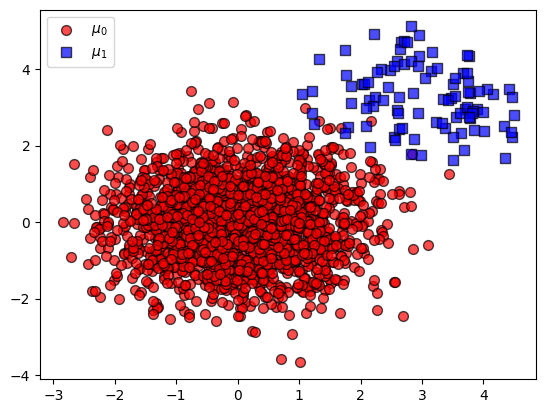

In [3]:
sampled_geom = geom.sample(rng_sample_geom, 2048)  # sample 256 points

fig, ax = plt.subplots()
dict_kw = plot.get_plotkwargs(background=False)
dict_kw_b = plot.get_plotkwargs(background=True)

x = sampled_geom.x
ax.scatter(x[:, 0], x[:, 1], **dict_kw["x"])
ax.scatter(sampled_geom.y[:, 0], sampled_geom.y[:, 1], **dict_kw["y"])
_ = ax.legend()

## Solving the semidiscrete OT problem

We can solve the (unregularized) {class}`semidiscrete problem <ott.problems.linear.semidiscrete_linear_problem.SemidiscreteLinearProblem>` using the {class}`~ott.solvers.linear.semidiscrete.SemidiscreteSolver`. Important arguments to the solver include:

- ``num_iterations`` - total number of iterations,
- ``batch_size`` - number of samples to draw from the source distribution at each iteration,
- ``optimizer`` - optimizer to use, such as {func}`optax.sgd`.


In [4]:
error_eval_every = 5000


def print_callback(state: semidiscrete.SemidiscreteState) -> None:
    it = state.it.item()
    if it > 0 and it % error_eval_every == 0:
        loss = state.errors[it // error_eval_every - 1].item()
        print(f"It. {it:5d}, marginal χ2 error={loss:.4f}")


@jax.jit
def solve_semidiscrete(
    rng: jax.Array, geom: sdpc.SemidiscretePointCloud
) -> semidiscrete.SemidiscreteOutput:
    prob = sdlp.SemidiscreteLinearProblem(geom)
    solver = semidiscrete.SemidiscreteSolver(
        num_iterations=30_000,
        batch_size=128,
        optimizer=optax.sgd(learning_rate=0.1),
        error_eval_every=error_eval_every,
        callback=print_callback,
    )
    return solver(rng, prob)

We evaluate and print the marginal χ2 error between the ground-truth and estimated target marginal every 5000 iterations.

In [5]:
out = solve_semidiscrete(rng, geom)

It.  5000, marginal χ2 error=0.3863
It. 10000, marginal χ2 error=0.0217
It. 15000, marginal χ2 error=0.0054
It. 20000, marginal χ2 error=-0.0034
It. 25000, marginal χ2 error=0.0290
It. 30000, marginal χ2 error=-0.0094


And plot the evolution of the marginal χ2 error along the iterations.

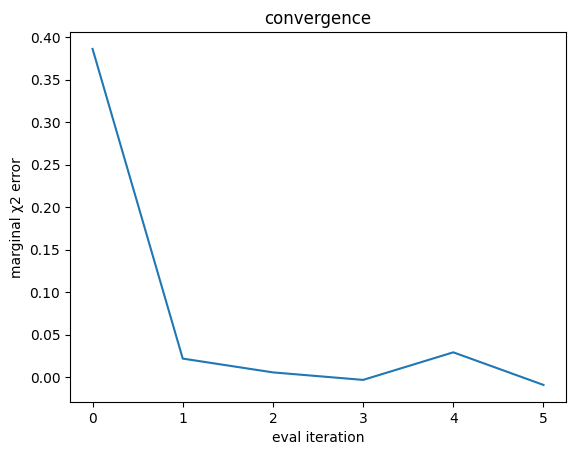

In [6]:
fig, ax = plt.subplots()
ax.plot(out.errors)
ax.set_title("convergence")
ax.set_xlabel("eval iteration")
_ = ax.set_ylabel("marginal χ2 error")

We can use {meth}`SemidiscreteOutput.sample <ott.solvers.linear.semidiscrete.SemidiscreteOutput.sample>` to sample some points from the from the source distribution and compute the optimal transport plan between these points and the target distribution.

In the unregularized case $\varepsilon = 0$, the transport matrix will be stored as a sparse {class}`~jax.experimental.sparse.BCOO` matrix.

In [7]:
out_sampled = out.sample(rng_sample_out, 16)
out_sampled.matrix

BCOO(float32[16, 96], nse=16)

In [8]:
_, col_ixs = out_sampled.matrix.indices.T

sampled_geom = out_sampled.ot_prob.geom
x_new = sampled_geom.x
y_new = sampled_geom.y
matched_y = y[col_ixs]
delta = matched_y - x_new

Below, we show the sampled source points along with their matches in the target distribution.

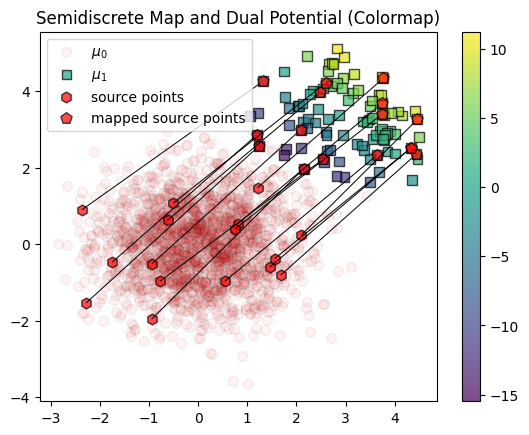

In [9]:
fig, ax = plt.subplots()
# A few changes to plot defaults
dict_kw["x"].update({"alpha": 0.05})  # let source points fade
dict_kw["y"].pop("color", None)  # remove original color
dict_kw["y"].update({"c": out.g})  # plot dual variables on top

ax.scatter(x[:, 0], x[:, 1], **dict_kw["x"])
bar = ax.scatter(y[:, 0], y[:, 1], **dict_kw["y"])

ax.scatter(x_new[:, 0], x_new[:, 1], **dict_kw["xnew"], label="source points")
ax.scatter(
    matched_y[:, 0],
    matched_y[:, 1],
    **dict_kw["txnew"],
    label="mapped source points",
)

ax.quiver(
    x_new[:, 0],
    x_new[:, 1],
    delta[:, 0],
    delta[:, 1],
    scale_units="xy",
    angles="xy",
    scale=1.0,
    width=0.0025,
    headwidth=0,
)
fig.colorbar(bar)
plt.title("Semidiscrete Map and Dual Potential (Colormap)")
_ = ax.legend()